![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Exercise 3: Transfer Learning </center>
### <center> Dogs VS. Cats - Solution </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/Exercises/Ex3/MainDogsVsCats_Solution.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn               as nn
import torch.optim            as optim
import torchvision
import torchvision.transforms as transforms
import torchsummary

from torch.optim import lr_scheduler

matplotlib.rc('font', **{'size' : 16})

### Download Dogs vs. Cats dataset:
https://www.kaggle.com/shaunthesheep/microsoft-catsvsdogs-dataset

In [4]:
import torchvision
import torchvision.transforms as transforms

vMean = np.array([0.48501961, 0.45795686, 0.40760392])
vStd  = np.array([0.22899216, 0.224     , 0.225     ])

oTransforms = transforms.Compose([
    transforms.Resize    (256),
    transforms.CenterCrop(224),
    transforms.ToTensor  (),
    transforms.Normalize (mean=vMean, std=vStd),
])

dirPath = r'C:\Users\oryai\Workarea\Data\DogsVsCats\PetImages'

oDataSet = torchvision.datasets.ImageFolder(root=dirPath, transform=oTransforms)
lClasses = oDataSet.classes
lClasses

['Cat', 'Dog']

In [5]:
N                   = len(oDataSet)
nTrain              = 22500
nTest               = 2498
oTrainSet, oTestSet = torch.utils.data.random_split(oDataSet, [nTrain, nTest], generator=torch.Generator().manual_seed(42))
len(oTrainSet), len(oTestSet)

(22500, 2498)

### Plot some examples:

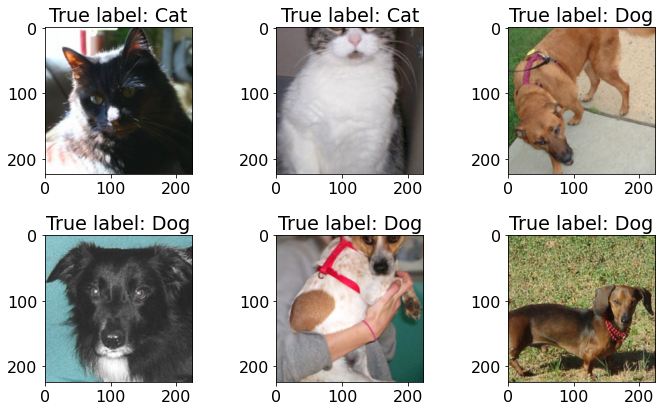

In [6]:
C, H, W = oTrainSet[0][0].shape
fig, _     = plt.subplots(2, 3, figsize=(10,6))
for ax in fig.axes:
    idx   = np.random.randint(0, len(oTrainSet))
    mX, y = oTrainSet[idx]
    mX    = mX * vStd[:,None,None] + vMean[:,None,None] #-- unnormalizing
    mX    = torch.clamp(mX, 0, 1)
    ax.imshow(np.transpose(mX.numpy(), (1,2,0)), cmap='gray')
    ax.set_title('True label: ' + str(lClasses[y]))
    
plt.tight_layout()
plt.show()

### Create data loaders:

In [7]:
batchSize = 256
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2)

In [8]:
import torch.nn as nn
import torchsummary

def GetModel():
    oModel = torchvision.models.resnet50(pretrained=True)
    for mParam in oModel.parameters():
        mParam.requires_grad = False
        
    dIn = oModel.fc.in_features
    oModel.fc = nn.Sequential(
        nn.Linear(dIn, 100), nn.ReLU(),
        nn.Linear(100, 2)
    )
    
    return oModel

torchsummary.summary(GetModel(), (3, 224, 224), device='cpu');

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [9]:
Loss   = nn.CrossEntropyLoss()
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
DEVICE

device(type='cuda', index=0)

In [10]:
from DeepLearningFramework_Solution.Training import TrainClassficationModel

nEpochs    = 10
nIter      = nEpochs * len(oTrainDL)

oModel     = GetModel().to(DEVICE)
oOptim     = optim.AdamW(oModel.parameters(), lr=3e-4, betas=(0.9, 0.99), weight_decay=2e-4)
oScheduler = lr_scheduler.OneCycleLR(oOptim, max_lr=1e-2, total_steps=nIter)

lHistory   = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oScheduler)

Epoch 000: | Train loss:  0.095 | Val loss:  0.046 | Train Accuracy:  0.972 | Val Accuracy:  0.984 | epoch time: 45.672 | <-- Checkpoint!
Epoch 001: | Train loss:  0.064 | Val loss:  0.058 | Train Accuracy:  0.977 | Val Accuracy:  0.980 | epoch time: 45.655 |
Epoch 002: | Train loss:  0.075 | Val loss:  0.071 | Train Accuracy:  0.973 | Val Accuracy:  0.974 | epoch time: 45.727 |
Epoch 003: | Train loss:  0.050 | Val loss:  0.080 | Train Accuracy:  0.981 | Val Accuracy:  0.968 | epoch time: 46.108 |
Epoch 004: | Train loss:  0.043 | Val loss:  0.050 | Train Accuracy:  0.983 | Val Accuracy:  0.983 | epoch time: 46.052 |
Epoch 005: | Train loss:  0.039 | Val loss:  0.047 | Train Accuracy:  0.986 | Val Accuracy:  0.982 | epoch time: 46.502 |
Epoch 006: | Train loss:  0.033 | Val loss:  0.041 | Train Accuracy:  0.987 | Val Accuracy:  0.984 | epoch time: 45.860 | <-- Checkpoint!
Epoch 007: | Train loss:  0.029 | Val loss:  0.043 | Train Accuracy:  0.989 | Val Accuracy:  0.984 | epoch time: 4

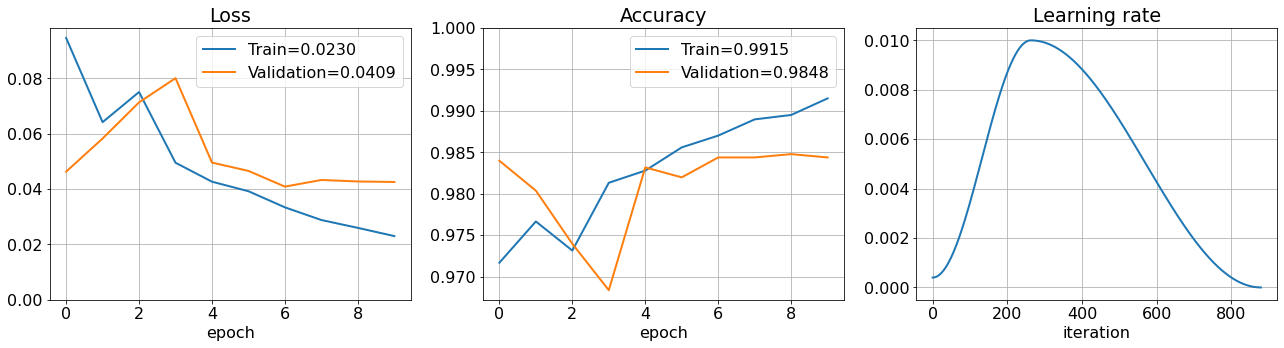

In [11]:
from DeepLearningFramework_Solution.Auxiliary import PlotHistory

PlotHistory(lHistory)